In [2]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score

sns.set(style="darkgrid")
seed = 99

## Connect to the MLClient and workspace, create a data asset

In [3]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

ml_client = MLClient(
    DefaultAzureCredential(), "e1f27d73-68d8-4f59-900b-77783d4c5b3b", "End2EndCPC", "End2End_CPC"
)



In [4]:
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes

my_path = './data/kw_dataset.csv'

my_data = Data(
    path=my_path,
    type=AssetTypes.URI_FILE,
    description="Data asset pointing to a local file, automatically uploaded to the default datastore",
    name="kw-dataset"
)

ml_client.data.create_or_update(my_data)

Data({'path': 'azureml://subscriptions/e1f27d73-68d8-4f59-900b-77783d4c5b3b/resourcegroups/End2EndCPC/workspaces/End2End_CPC/datastores/workspaceblobstore/paths/LocalUpload/cfa68266a7eb32eccba0487675db2231/kw_dataset.csv', 'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': None, 'type': 'uri_file', 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'kw-dataset', 'description': 'Data asset pointing to a local file, automatically uploaded to the default datastore', 'tags': {}, 'properties': {}, 'print_as_yaml': False, 'id': '/subscriptions/e1f27d73-68d8-4f59-900b-77783d4c5b3b/resourceGroups/End2EndCPC/providers/Microsoft.MachineLearningServices/workspaces/End2End_CPC/data/kw-dataset/versions/1', 'Resource__source_path': '', 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/notebook-compute-cpc/code/Users/miguel_lopez_virues/keyword_CPC', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 

#### Read the data

In [6]:
registered_data_asset = ml_client.data.get(name='kw-dataset', version='1')
registered_data_asset
# df = pd.read_csv.to_pandas_dataframe()


AttributeError: 'Data' object has no attribute 'to_pandas_dataframe'

##### Functions

In [294]:
def cramers_v(confusion_matrix):
    """Calculate Cramér's V for a given confusion matrix."""
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min((k - 1), (r - 1)))

def cramers_v_matrix(df):
    """Calculate the Cramér's V correlation matrix for a given DataFrame."""
    cols = df.columns
    num_cols = len(cols)
    cramers_v_mat = pd.DataFrame(np.zeros((num_cols, num_cols)), columns=cols, index=cols)

    for col1 in cols:
        for col2 in cols:
            if col1 == col2:
                cramers_v_mat.loc[col1, col2] = 1.0
            else:
                confusion_matrix = pd.crosstab(df[col1], df[col2])
                cramers_v_mat.loc[col1, col2] = cramers_v(confusion_matrix)
                
    return cramers_v_mat


In [295]:
class OutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, method="cap", threshold=3):
        self.threshold = threshold
        self.method = method

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X = X.values
        self.Q3_list = np.percentile(X, 75, axis=0)
        self.Q1_list = np.percentile(X, 25, axis=0)
        self.IQR_list = self.Q3_list - self.Q1_list
        self.lower_bound_list = self.Q1_list - self.threshold * self.IQR_list
        self.upper_bound_list = self.Q3_list + self.threshold * self.IQR_list
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        X_transformed = X.copy()

        for col_idx in range(X.shape[1]):
            mask_upper = X[:, col_idx] > self.upper_bound_list[col_idx]
            mask_lower = X[:, col_idx] < self.lower_bound_list[col_idx]

            if self.method == "median":
                X_transformed[mask_upper, col_idx] = np.median(X[:, col_idx])
                X_transformed[mask_lower, col_idx] = np.median(X[:, col_idx])
            elif self.method == "mean":
                X_transformed[mask_upper, col_idx] = np.mean(X[:, col_idx])
                X_transformed[mask_lower, col_idx] = np.mean(X[:, col_idx])
            else:  # cap
                X_transformed[mask_upper, col_idx] = self.upper_bound_list[col_idx]
                X_transformed[mask_lower, col_idx] = self.lower_bound_list[col_idx]
            

        return X_transformed


### Import data

In [334]:
df_kw = pd.read_csv(r'C:\Users\Miguel\OneDrive\Data Science\Projects\KWdigital\kw_dataset.csv')

### Preliminary analysis and cleaning

- Data types 
- Categorical unique values
- Correct encodings
- Ranges of numerical features
- Missing data
- Outliers

In [335]:
df_kw.head(10)

,keyword,competition,lower_bid,upper_bid,CPC
0,fibra futbol,58,0.51,2.07,1.45
1,fibra granada,54,0.83,3.26,1.64
2,fibra hogar,62,1.45,4.65,2.41
3,fibra internet,66,0.96,3.46,1.71
4,fibra internet barata,66,0.83,3.10,1.84
5,fibra internet casa,67,1.25,3.98,2.24
6,fibra internet mas barata,52,0.77,2.80,1.24
7,fibra internet ofertas,63,0.89,2.90,1.73
8,fibra internet sin permanencia,53,1.36,3.46,2.42
9,fibra leon,45,0.80,3.05,2.01


In [298]:
df_kw.info()
df_kw.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1293 entries, 0 to 1292
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   keyword      1293 non-null   object 
 1   competition  1293 non-null   int64  
 2   lower_bid    1293 non-null   float64
 3   upper_bid    1293 non-null   float64
 4   CPC          1293 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 50.6+ KB


keyword        1293
competition      94
lower_bid       215
upper_bid       479
CPC             327
dtype: int64

As can be seen above, the data types are mostly correct. The _keyword_ feature could be converted to a category type, but given the high cardinality it will serve no predictive purpose, so it can be dropped.

In [299]:
df_kw = df_kw.drop("keyword",axis=1)

Inspecting the numerical feature ranges, there seems to be no out of range value or numerically encoded missing values. There no missing values correctly encoded as such either.

In [300]:
display(df_kw.describe())
df_kw.isna().sum()

,competition,lower_bid,upper_bid,CPC
count,1293.000000,1293.000000,1293.000000,1293.000000
mean,44.091261,0.882622,3.118894,1.505739
std,26.961147,0.898796,3.737470,1.112766
min,0.000000,0.000000,0.000000,0.010000
25%,18.000000,0.420000,1.720000,0.770000
50%,53.000000,0.700000,2.590000,1.270000
75%,62.000000,1.170000,3.960000,2.060000
max,100.000000,16.730000,70.800000,18.130000


competition    0
lower_bid      0
upper_bid      0
CPC            0
dtype: int64

However, as can be observed by the summary of the _describe()_ function above, the lower and upper bids have a minimum of 0. Although not numerically incorrect, those values should always be higher than 0 as to take part in the bidding process and have a CPC result, one must provide a positive value for both bids. 

These values should be encoded as NaN, but as these 2 columns make up for more than a 50% of the predictor features, a 66,6% NaN values row would input little information to the model. Hence, they are dropped directly.

In [301]:
zero_mask = (df_kw['lower_bid']==df_kw['upper_bid'])|(df_kw['lower_bid']==0)
display(df_kw[zero_mask])
df_kw = df_kw[~zero_mask]
df_kw.shape

,competition,lower_bid,upper_bid,CPC
94,30,0.0,0.0,1.39
185,0,0.0,0.0,0.42
187,3,0.0,0.0,0.58
231,1,0.0,0.0,0.48
234,4,0.0,0.0,1.03
...,...,...,...,...
1241,0,0.0,0.0,0.93
1246,0,0.0,0.0,0.17
1247,0,0.0,0.0,0.17
1252,0,0.0,0.0,0.09


(1223, 4)

Similarly, the lower bid should never be higher than the upper bid or the final CPC price, just as the upper_bid must be the maximum value to pay for CPC.

In [302]:
lower_mask = (df_kw['lower_bid']>df_kw['upper_bid'])|(df_kw['lower_bid']>df_kw['CPC'])|(df_kw['upper_bid']<df_kw['CPC'])
display(df_kw[lower_mask])
df_kw = df_kw[~lower_mask]
df_kw.shape

,competition,lower_bid,upper_bid,CPC
47,28,1.18,1.19,0.86
61,49,1.18,1.20,1.30
107,58,1.18,1.20,0.72
125,11,1.09,1.88,0.67
226,23,1.40,2.53,1.28
...,...,...,...,...
1250,8,2.57,2.59,2.82
1253,9,0.41,0.53,0.57
1254,15,0.37,0.53,0.64
1255,14,2.22,2.58,1.78


(1119, 4)

In [303]:
df_kw.describe()

,competition,lower_bid,upper_bid,CPC
count,1119.000000,1119.000000,1119.000000,1119.000000
mean,48.904379,0.840277,3.260438,1.494290
std,24.835861,0.549267,3.233964,0.987605
min,0.000000,0.010000,0.080000,0.040000
25%,30.000000,0.470000,1.915000,0.810000
50%,56.000000,0.700000,2.680000,1.280000
75%,63.000000,1.120000,4.160000,2.010000
max,100.000000,4.990000,70.800000,12.400000


### Exploratory analysis

With the incorrect values corrected, let's check the distributions for outliers and the interactions between features and the response via a pairplot.

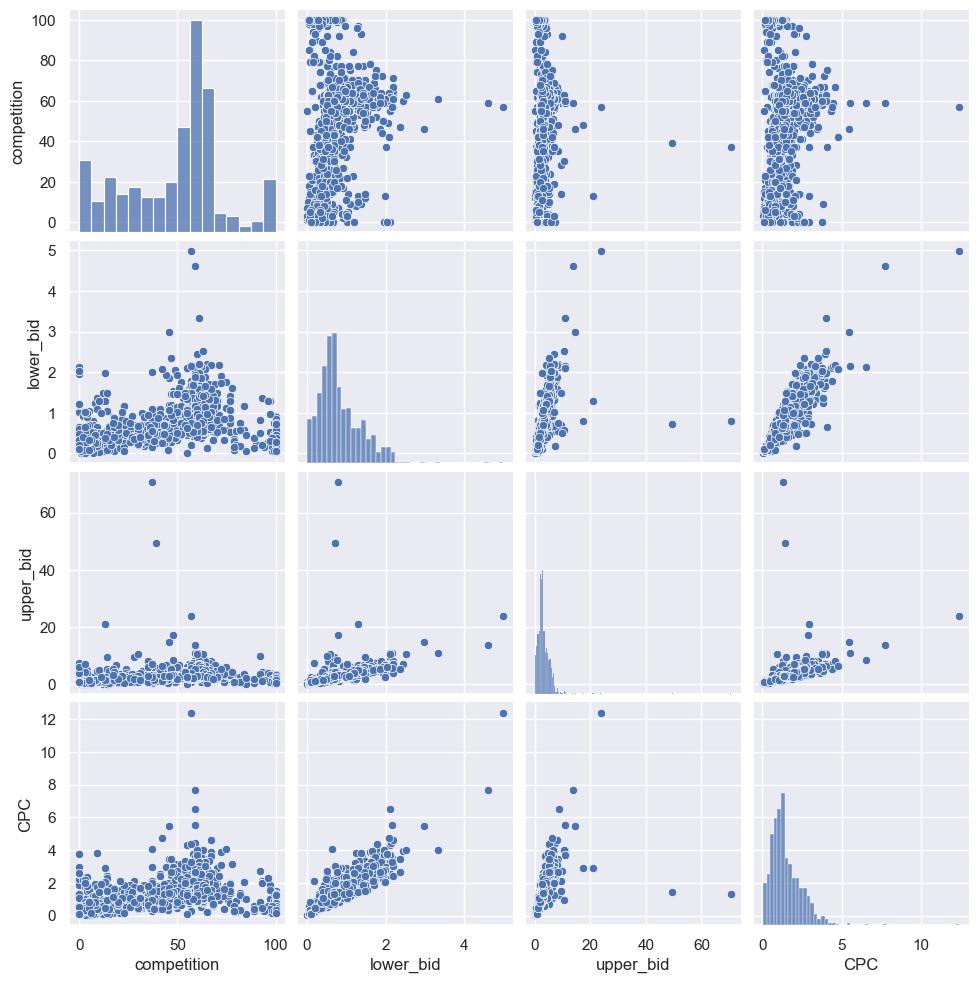

In [304]:
sns.pairplot(df_kw)
plt.show()

From the visual inspection of pairplot, it can be stated that the current competition values bear no correlation at all with the bidding or the CPC for this dataset, which is surprising. On the other hand, the lower bid holds a strong correlation with what seems a low effect due to the scale of the plot that should actually have a slope of around 1, while the upper bid also shows a weaker correlation with a stronger effect of a higher slope.

The lower and upper bid, as well as the CPC show a right skewed distribution, which together with the scatterplots report the presence of some possible outliers that will be treated later on. 

To confirm the relationships between the variables, let's inspect their Pearson's correlation values and fit a regression line of each feature.

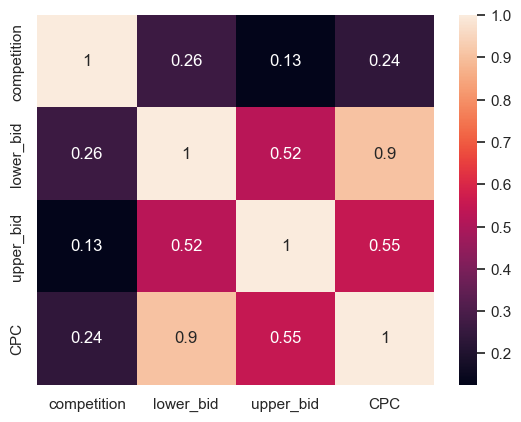

In [305]:
sns.heatmap(df_kw.corr(),annot=True)
plt.show()

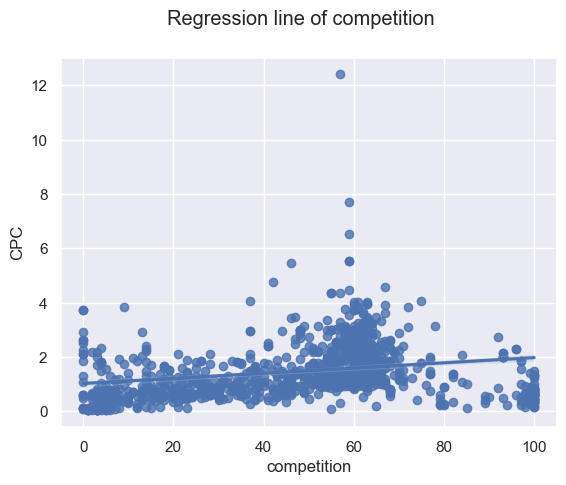

The slope for competition is: 0.009494016398788503


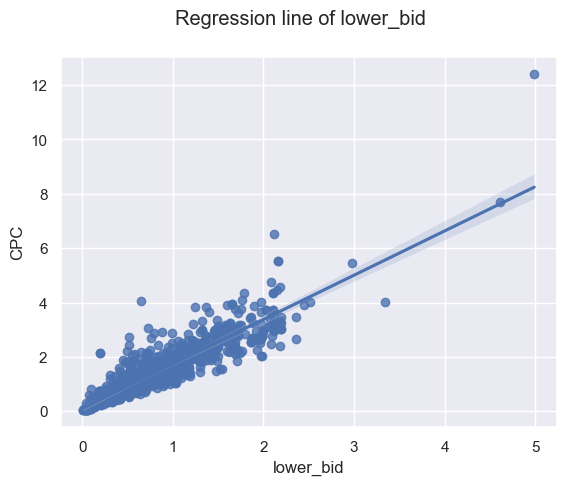

The slope for lower_bid is: 1.6269086372364068


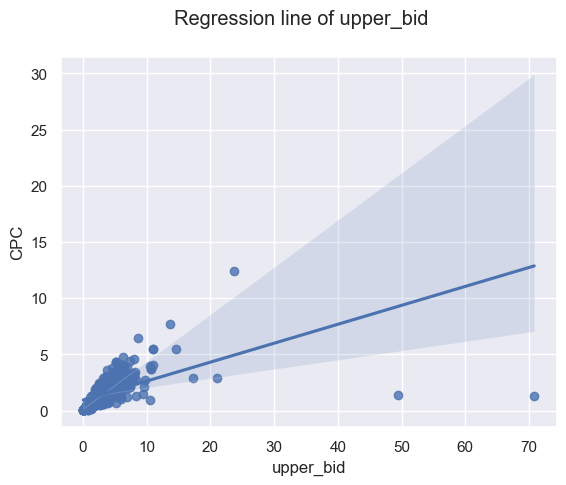

The slope for upper_bid is: 0.1685643447213626


In [306]:
for feature in df_kw.drop("CPC",axis=1).columns.to_list():
    sns.regplot(data=df_kw,x=feature,y="CPC")
    plt.suptitle(f"Regression line of {feature}")
    plt.show()

    print(f"The slope for {feature} is:",stats.linregress(df_kw[feature],df_kw["CPC"]).slope)

The slope for the competition variable is very low,and together with the mild Pearson's correlation coefficient, its influence in the final model is expected to be low provided it is linear. The lower_bid fits with precision and has a slope of 1.62, indicating that for each increment in lower bid, a 1.62 increment in CPC is made. Finally, the slope for the upper_bid is lower than expected and it seems that might be caused by the outliers with upper bid value around 50 and 70. Therefore, it should be assesed whether:
1. These points are really outliers. The method of choice is the 3IQR rule, bearing in mind that the outlier incidence should not be higher than 10%, otherwise they make part of a skewed distribution.
2. In case they are outliers, these points should be dropped or not. It will depend on the model of choice, as linear regression is really sensitive to outliers and more outlier-robust models like Random Forest can handle them without so much impact on error.

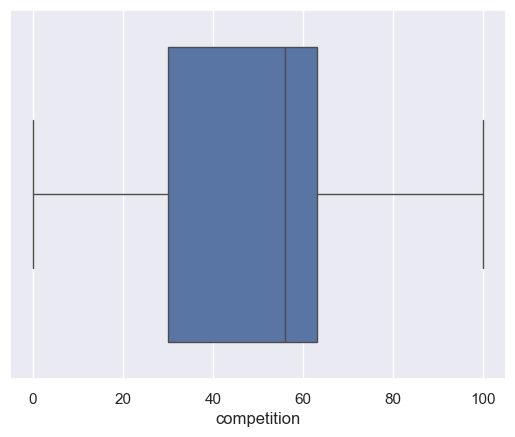

Series([], Name: competition, dtype: int64)

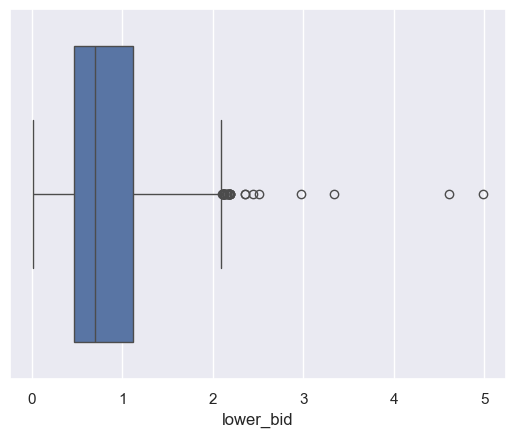

408    4.99
430    4.61
784    3.34
Name: lower_bid, dtype: float64

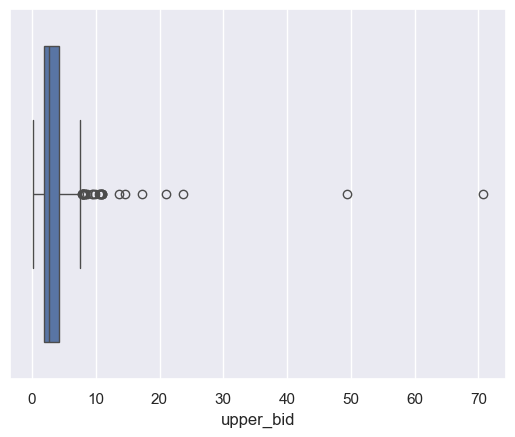

408     23.68
430     13.62
431     49.40
446     14.62
448     70.80
449     17.32
784     10.96
844     11.02
845     11.02
1069    20.99
Name: upper_bid, dtype: float64

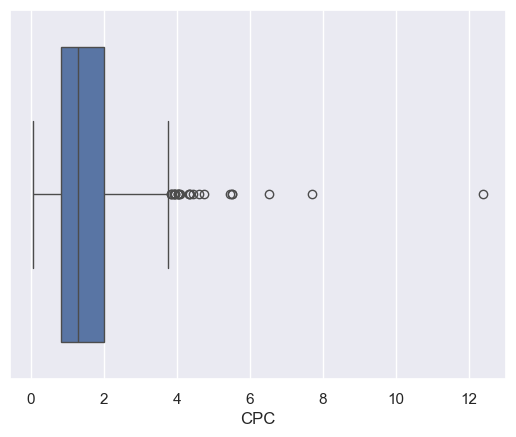

408    12.40
430     7.69
440     6.51
Name: CPC, dtype: float64

In [307]:
for feature in df_kw:
    sns.boxplot(df_kw,x=feature)
    plt.show()
    IQR_3_limit = df_kw[feature].quantile(0.75) + (df_kw[feature].quantile(0.75) - df_kw[feature].quantile(0.25))*3 
    display(df_kw.loc[df_kw[feature]>IQR_3_limit,feature])

There are a few outliers that match the criteria. However, in order to not introduce data leakeage, these should be treated inside the preprocessing pipeline to have the treatment technique fitted on training data and evaluated on test data to properly assess the impact of the treatment. 

For exploratory purposes, let's visually evaluate the impact of those outliers.

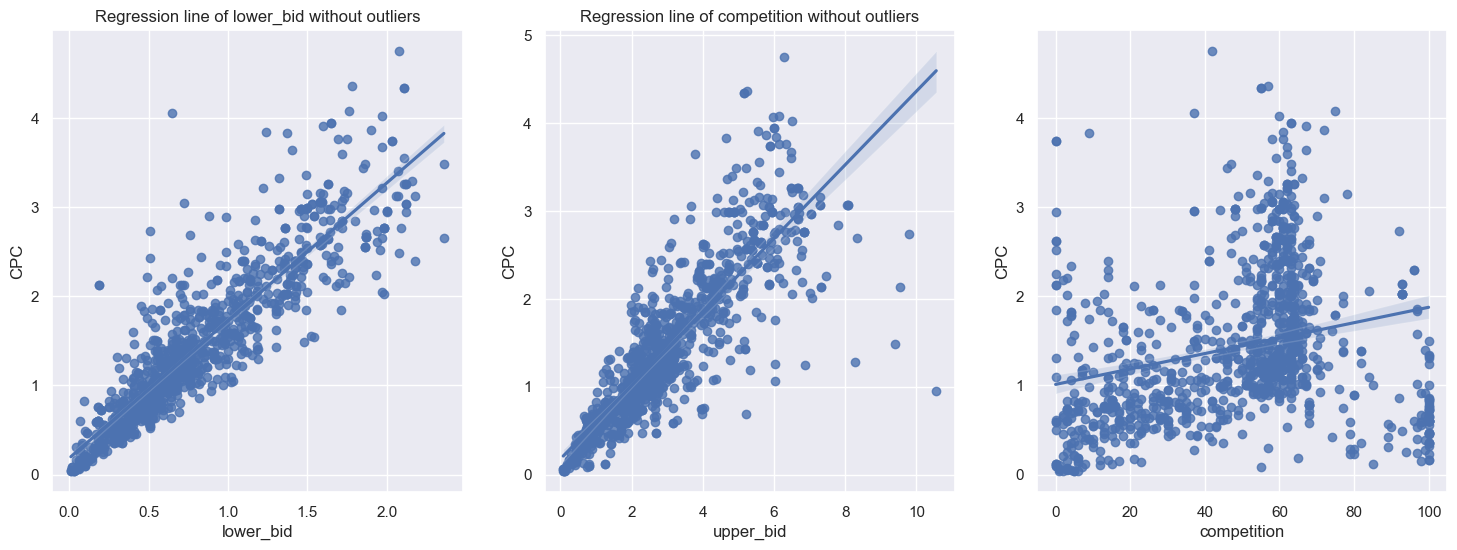

In [318]:
df_kw_no_outliers = df_kw.copy()
for feature in df_kw_no_outliers:
    IQR_3_limit = df_kw_no_outliers[feature].quantile(0.75) + (df_kw_no_outliers[feature].quantile(0.75) - df_kw_no_outliers[feature].quantile(0.25))*3
    df_kw_no_outliers[df_kw_no_outliers[feature]>IQR_3_limit] = np.nan
    
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
sns.regplot(data=df_kw_no_outliers,x="lower_bid",y="CPC", ax=ax1)
sns.regplot(data=df_kw_no_outliers,x="upper_bid",y="CPC", ax=ax2)
sns.regplot(data=df_kw_no_outliers,x="competition",y="CPC", ax=ax3)
ax1.set_title("Regression line of lower_bid without outliers")
ax2.set_title("Regression line of upper_bid without outliers")
ax2.set_title("Regression line of competition without outliers")
plt.show()
    

Revisiting the distributions, it could be suggested to also preprocess the predictor features with a power transformation to make the data more gaussian-like and aid the linear regression algorithm in extracting the information from the data.

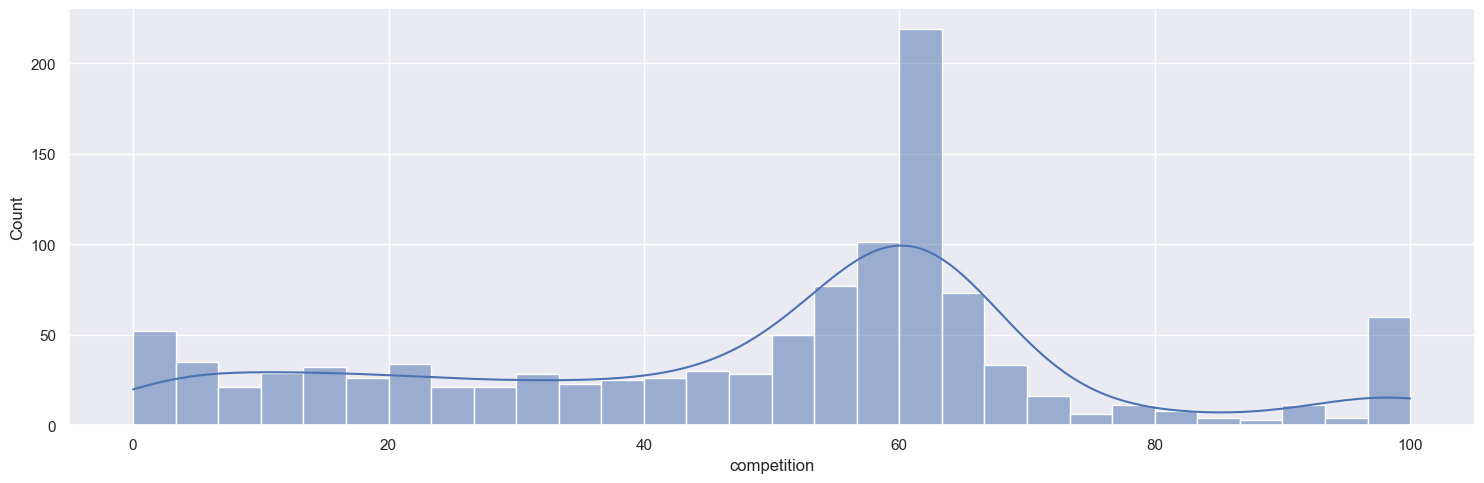

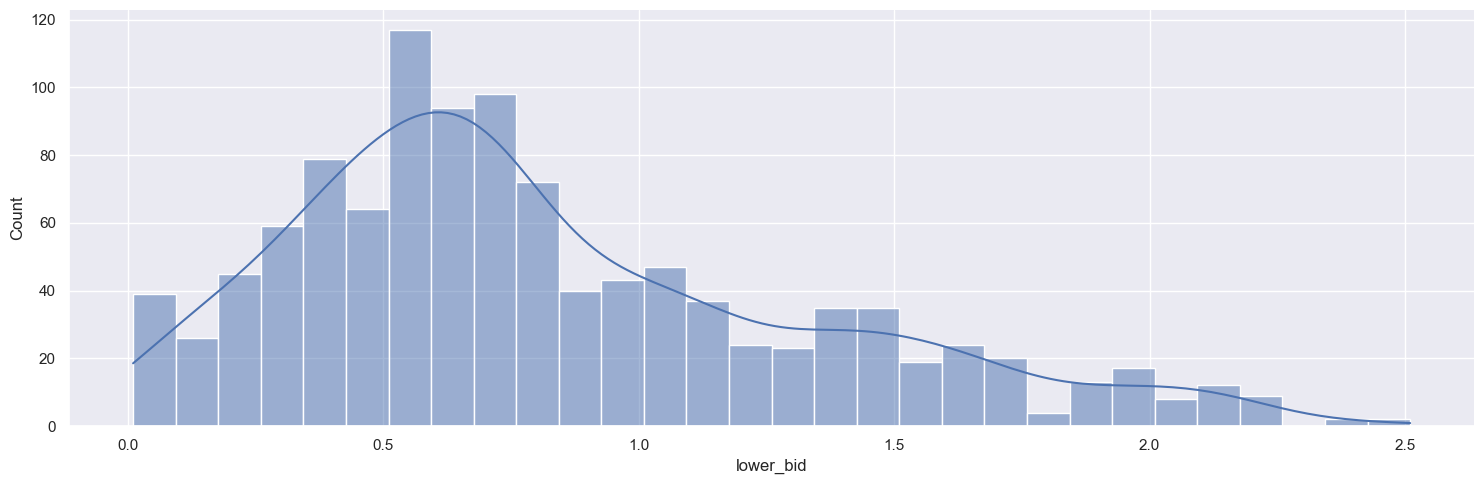

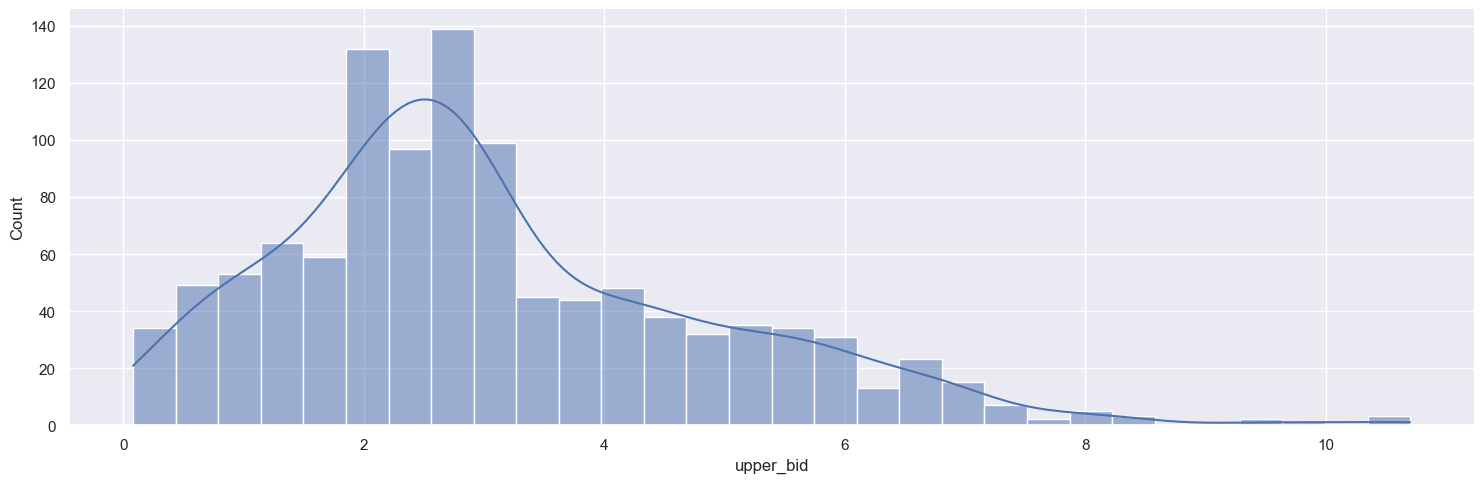

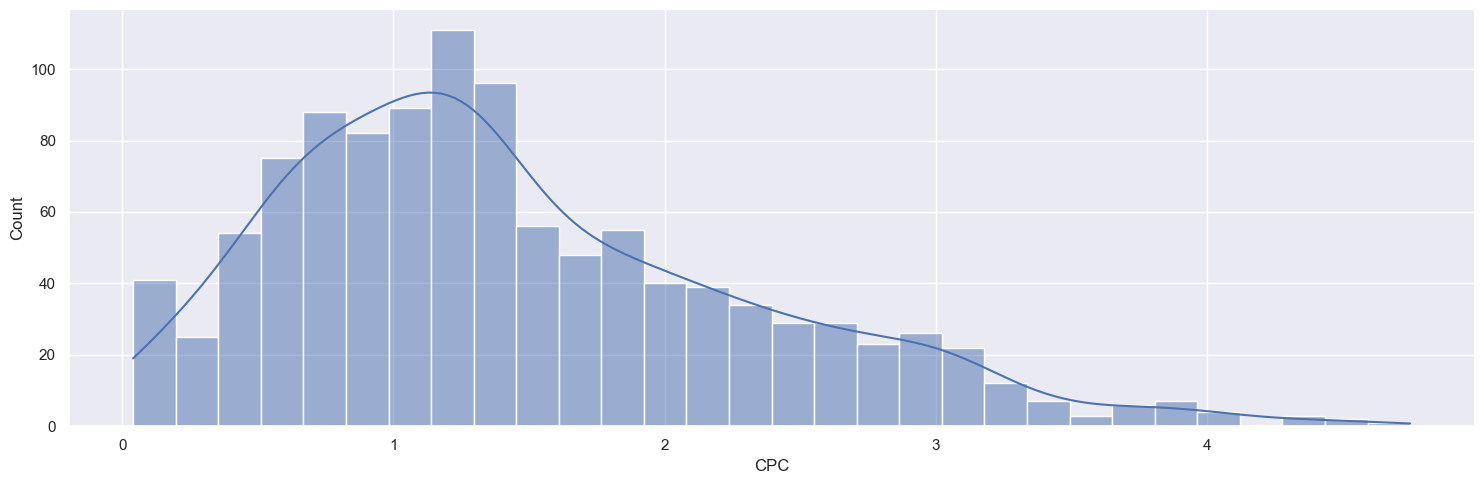

In [309]:
for feature in df_kw_no_outliers:
    sns.displot(df_kw_no_outliers,x=feature,bins=30, kde=True,aspect=3)

Also, a simple interaction term can be added to complete the information for the case of the linear regression model.

In [310]:
df_kw['bid_interaction'] = df_kw['lower_bid']*df_kw['upper_bid']

Three models will be evaluated.
- Linear regression: For its training speed, simplicity and explicability. Moreover, the data is shows a highly linear behaviour.
- Random forest: For its robustness against outliers. Being a non-linear algorithm, it can help extract hidden patterns in the not so linear feature of the competition. It can also yield good explicability through its feature importances.
- Gradient boosting: For its power as with every subsequent tree it tries to cover or correct the sets of points where it had the higher error.

In [323]:
X, y = df_kw[["competition","upper_bid","lower_bid","bid_interaction"]], np.ravel(df_kw[["CPC"]])

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=seed)

lr_pipeline = Pipeline([
    ('outlier_capper', OutlierCapper(method="cap"))
])

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=seed),
    'Gradient Boosting': GradientBoostingRegressor(random_state=seed)
}

model_scores = {
    'Linear Regression': None,
    'Random Forest': None,
    'Gradient Boosting': None
}
# Cross-validate each model
for model_name, model in models.items():
    if model_name == 'Linear Regression':
        pipeline = Pipeline([
            ('lr_preprocessing', lr_pipeline),
            ('model', model)
        ])
    else:
        pipeline = model

    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=50, scoring='neg_mean_squared_error')
    model_scores[model_name] = np.sqrt(-cv_scores)
    print(f"{model_name}: Average RMSE: {model_scores[model_name].mean()}")


Linear Regression: Average RMSE: 0.3791430449491224
Random Forest: Average RMSE: 0.36147940031019
Gradient Boosting: Average RMSE: 0.3584784462768647


The three suggested models LR + capped outliers, RF and GB perform very similarly. Being gradient boosting the one that showcases the least variance and the smallest error af all three.

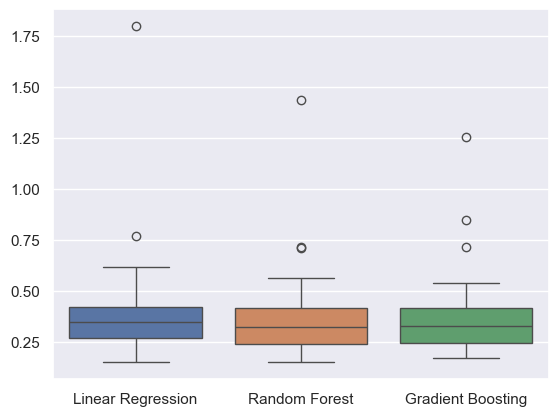

In [319]:
sns.boxplot(pd.DataFrame(model_scores))
plt.show()

The logistic regression is chosen for explicability and faster inference time:

In [320]:
pipeline = Pipeline([
    ('lr_preprocessing', lr_pipeline),
    ('model', LinearRegression())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_pred 

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"The chosen model is Linear Regression, with an average test RMSE of: {rmse}")

model = pipeline.named_steps['model']
coefficients = model.coef_

feature_names = X_train.columns
for feature, coef in zip(feature_names, coefficients):  # Flatten in case coefficients are in a 2D array
    print(f"{feature}: {coef}")
print("Model Coefficients:", coefficients)

The chosen model is Linear Regression, with an average test RMSE of: 0.3667217732214786
competition: -0.0005446615656961158
upper_bid: 0.21684387522042242
lower_bid: 1.4257828600594242
bid_interaction: -0.06212364027643873
Model Coefficients: [-5.44661566e-04  2.16843875e-01  1.42578286e+00 -6.21236403e-02]


As per the coefficients, we can see that the main driver up for the price is the lower_bid value. An upper_bid is not such a driver up of the price, although it can generally be an enabler of a higher CPC. The negative interaction term might indicate that when both the lower and upper bids are higher, the CPC tends to stay closer to the lower_bid as the higher the bids the higher the probability of beating your competition. Not far from expected, the competition term in the linear regression is negligible.